## Import the Necessary Files

In [3]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import imutils
import cv2

from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import shutil


In [4]:
# Path to the video File 
filename = '.../video.mp4'

if os.path.exists('output'):
    shutil.rmtree('output')

os.makedirs('output')

In [5]:
cap = cv2.VideoCapture(filename)
count = 0
while cap.isOpened():
    ret,frame = cap.read()
    if ret == True:
        cv2.imwrite("./output/frame%d.jpg" % count, frame)
        count = count + 1
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

The overall flow of the project is explained in the architecture diagram given below.

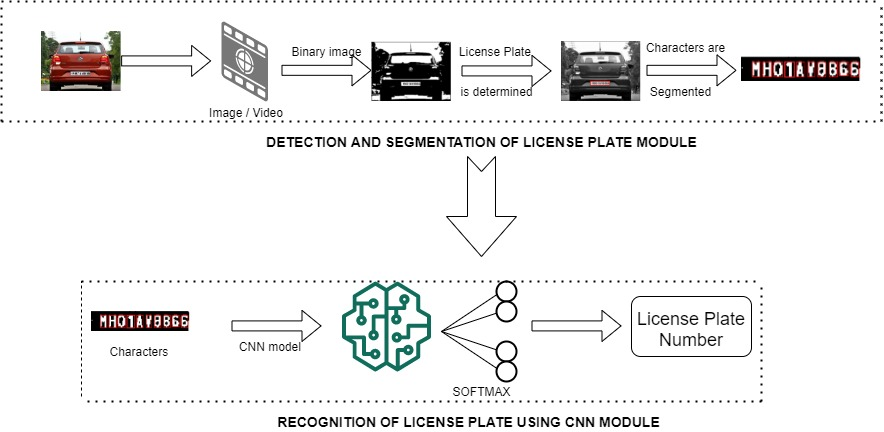

## Detection of License plate
In this detection stage, we preprocess the image. With preprocessing the readability of the characters increases so that it would be easy while the image is passed to segmentation and recognition steps

In [6]:
car_image = imread("./output/frame%d.jpg"%(count-1), as_gray=True)
car_image = imutils.rotate(car_image, 270) # Rotate if the image is not straight
#car_image = imread("/content/17.PNG", as_gray=True)
print(car_image.shape) # 2 dimensional Array

(1080, 1920)


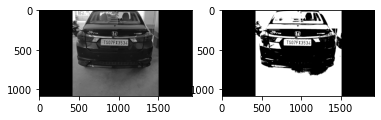

In [7]:
#convert RGB to gray scale and binary image
gray_car_image = car_image * 30
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap="gray")
plt.show()

In [ ]:
# Find the connected region of license plate
label_image = measure.label(binary_car_image)
# Sample Plate dimensions
plate_dimensions = (0.03*label_image.shape[0], 0.08*label_image.shape[0], 0.15*label_image.shape[1], 0.3*label_image.shape[1])
plate_dimensions2 = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions
plate_objects_cordinates = []
plate_like_objects = []

fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray")
flag =0

for region in regionprops(label_image):
    if region.area < 50:
        continue
    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row - min_row
    region_width = max_col - min_col

    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        flag = 1
        plate_like_objects.append(binary_car_image[min_row:max_row,min_col:max_col])

        plate_objects_cordinates.append((min_row, min_col,max_row, max_col))

        rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",linewidth=2, fill=False)
        
        ax1.add_patch(rectBorder) # Draw rectangle box over the license plate 
        

if(flag == 1):
    plt.show()

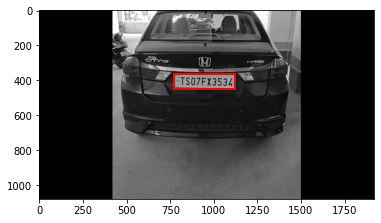

In [10]:
if(flag==0):
    min_height, max_height, min_width, max_width = plate_dimensions2
    plate_objects_cordinates = []
    plate_like_objects = []

    fig, (ax1) = plt.subplots(1)
    ax1.imshow(gray_car_image, cmap="gray")

    for region in regionprops(label_image):
        if region.area < 50:
            continue
        min_row, min_col, max_row, max_col = region.bbox
        region_height = max_row - min_row
        region_width = max_col - min_col

        if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:

            plate_like_objects.append(binary_car_image[min_row:max_row,min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col,max_row, max_col))
            rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",linewidth=2, fill=False)
            
            ax1.add_patch(rectBorder) # Draw a rectangular box over the license plate
           
   
    plt.show()

# Segmentation of Characters 
As a first part, we invert the license plate from black pixel to white pixel and vice versa. In this step, we again specify the width of the license plate and ensure that it does not exceeds the specified width. We use region props available in skimage and patches from matplotlib to make the boxes over the characters. The boxed characters are resized and append it to a list so that we don’t change the order in which we are predicting the letters.

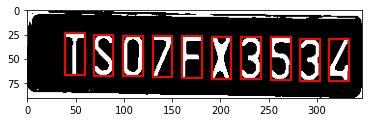

In [11]:
import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import matplotlib.pyplot as plt

license_plate = np.invert(plate_like_objects[0]) # Convert the Black Pixel to White pixel and vice versa

labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

character_dimensions = (0.45*license_plate.shape[0], 0.70*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a rectanglular box over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        resized_char = resize(roi, (30, 30)) # Resize the characters and append to the list
        characters.append(resized_char)
        column_list.append(x0)

plt.show()


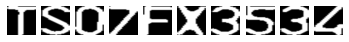

In [ ]:
for i in range(len(characters)):
    plt.subplot(1, 10, i+1)
    plt.imshow(characters[i], cmap='gray')
    plt.axis('off')

#Develop a  OCR Model in Tensor Flow to recognize the characters
Built a 2 layer convolutional ocr model to recognize the characters. The model is trained with several types of characters such as smooth image, blurred images and many more. 

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/train_up',  # train target directory
        target_size=(28,28), 
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/data/val',  # target validation directory
        target_size=(28,28),  
        class_mode='categorical')

Found 1229 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [ ]:
model = Sequential()

model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy',  optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

model.summary()

In [ ]:
log_dir="logs/fit/" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



In [ ]:
batch_size = 1
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 150 ,callbacks=[tensorboard_callback])


# Visualize the performance of model in Tensor Board

In [ ]:
%load_ext tensorboard

In [ ]:
#!kill 392
%tensorboard --logdir /content/logs

# Recognize the Characters
The trained ocr model is used to recognize the characters that are segmented from the license plate.

In [ ]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    chars = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(chars):
        dic[i] = c

    output = []
    
    #iterate over characters
    for i,ch in enumerate(characters): 
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)

        # REsize the image to be passed to the model
        img = img.reshape(1,28,28,3)

        y_ = model.predict_classes(img)[0] 
        character = dic[y_] 
        output.append(character)
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

TS07FX3534
